In [1]:
from gnssr import cygnss as cyg
import matplotlib.pyplot as plt
import numpy as np

### read cygnss l1 data

In [2]:
path = 'D:\\data\\20200801\\cyg01.ddmi.s20200801-000000-e20200801-235959.l1.power-brcs.a31.d32.nc'
ds = cyg.read_data(path)

### extract variables

In [7]:
df_obs = cyg.extract_obs(ds,['ddm_snr','brcs'])
print('len(df_obs):',len(df_obs))
df_obs.head()

Info: Variable 'brcs' applies a maximum reduction along the 'delay' and 'doppler' dimensions.
len(df_obs): 689680


,ddm_snr,brcs
0,2.147518,NaN
1,4.753397,1.280344e+10
2,4.705440,6.942846e+09
3,4.301946,1.156356e+10
4,2.237703,NaN


### calculate surface reflectivity

In [8]:
df_sr = cyg.cal_sr(df_obs,ds,True)
print('len(df_sr):',len(df_sr))
df_sr.head()

The quality control criteria adopted for this function are as follows: 
                    1. quality_flags: s_band_powered_up, large_sc_attitude_err, black_body_ddm, ddm_is_test_pattern,  
                    direct_signal_in_ddm, low_confidence_gps_eirp_estimate, and sp_over_land 
                    2. sp_inc_angle: less than 65 degrees   
                    3. sp_rx_gain: greater than or equal to 0 
                    4. ddm_snr: greater than or equal to 2  
                    5. brcs_ddm_peak_bin_delay_row: between 4 and 15th 
len(df_sr): 98636


,ddm_snr,brcs,sr,sp_lat,sp_lon
3502,7.160536,3.081757e+10,-22.010879,-28.974260,138.466675
3503,6.241278,1.208066e+10,-23.861675,-32.525711,137.187164
3506,6.985051,2.903808e+10,-22.264199,-28.964478,138.495361
3507,6.205063,1.187128e+10,-23.942982,-32.516518,137.217499
3510,6.153731,2.275243e+10,-23.318681,-28.954685,138.524063


### filter data by location

In [10]:
df_region = cyg.filter_data_by_lonlat(df_sr,[50,100,20,30])
print('len(df_region):',len(df_region))
df_region.head()

len(df_region): 7149


,ddm_snr,brcs,sr,sp_lat,sp_lon
240786,3.216354,4.390080e+10,-25.228950,20.116072,82.341293
240790,2.216323,2.658492e+10,-27.409340,20.132486,82.365028
240794,2.201474,2.634922e+10,-27.449869,20.148863,82.388809
240798,3.279544,3.172984e+10,-26.644877,20.165253,82.412582
240802,3.732677,3.827245e+10,-25.833034,20.181633,82.436356


In [23]:
lats = np.fromfile('EASE2_M36km.lats.964x406x1.double', dtype=np.float64).reshape((406, 964))[:,0][::-1]  
lons = np.fromfile('EASE2_M36km.lons.964x406x1.double', dtype=np.float64).reshape((406, 964))[0,:] 

obs_arr_dict = cyg.grid_obs(df_sr,lats,lons,['sr','brcs']) #Be sure to note the starting latitude of the grid variable arrays
sr_arr = obs_arr_dict['sr']
print('sr_arr.shape:',sr_arr.shape)

Please check your input data, make sure the second parameter is latitude boundaries and the third parameter is longitude boundaries.
sr_arr.shape: (405, 963)


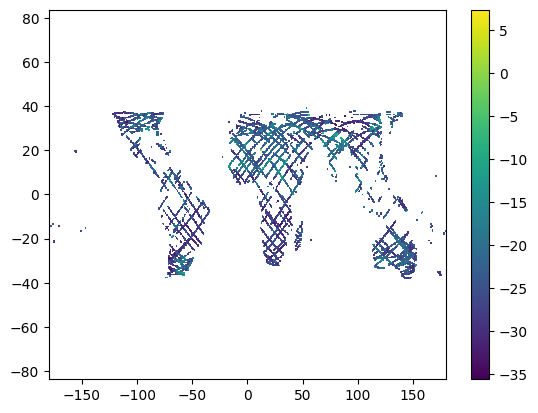

In [24]:
plt.pcolor(lons,lats,sr_arr)
plt.colorbar()

In [51]:
df_henan = cyg.filter_data_by_vector(df_sr,'henan.json')
df_henan.head()

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


,ddm_snr,brcs,sr,sp_lat,sp_lon
292696,3.968710,3.298744e+09,-28.950971,35.117546,112.062447
292700,3.825403,3.100014e+09,-29.216137,35.122288,112.095520
292704,2.757326,1.956711e+09,-31.210125,35.127014,112.128601
292708,3.004010,2.164772e+09,-30.766824,35.131737,112.161690
292712,3.019316,2.181921e+09,-30.727942,35.136440,112.194778


In [52]:
import geopandas as gpd
data = gpd.read_file('henan.json')
data

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


,adcode,name,childrenNum,level,parent,geometry
0,410000,河南省,18,province,"{ ""adcode"": 100000 }","MULTIPOLYGON (((111.00998 33.56054, 111.00369 ..."


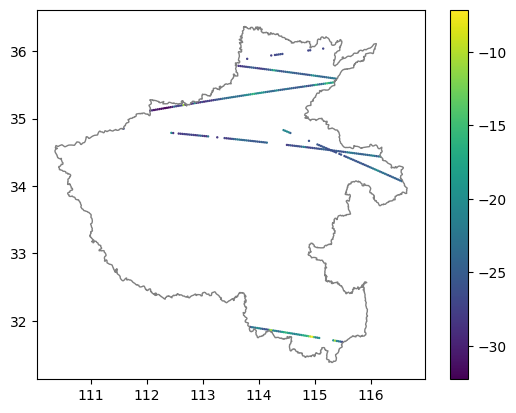

In [49]:
fig, ax = plt.subplots()  
data.boundary.plot(ax=ax, color='gray', linewidth=1)    
  
plt.scatter(df_henan['sp_lon'], df_henan['sp_lat'], c = df_henan['sr'],s = 0.5)  
plt.colorbar()  
plt.show()